In [ ]:
import os
import urllib.request
import tarfile
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, validation_curve
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import time

In [ ]:
def download_data(url, extract_dir):
    """
    Download and extract the dataset if it doesn't exist already
    """
    if not os.path.exists(extract_dir):
        os.makedirs(extract_dir)

    # Download the file
    tar_file_path = os.path.join(extract_dir, "ego-twitter.tar.gz")
    if not os.path.exists(tar_file_path):
        print(f"Downloading the dataset from {url}...")
        urllib.request.urlretrieve(url, tar_file_path)

    # Extract the file
    if not os.path.exists(os.path.join(extract_dir, "twitter")):
        print("Extracting the dataset...")
        with tarfile.open(tar_file_path, "r:gz") as tar:
            tar.extractall(extract_dir)

    print("Data download and extraction complete.")

In [ ]:
def load_network(ego_id, data_dir):
    """
    Load the network data for a specific ego ID
    """
    # Path to edge file
    edge_file = os.path.join(data_dir, "twitter", f"{ego_id}.edges")

    # Create a directed graph (since Twitter follows are directed)
    G = nx.DiGraph()

    # Add edges from the edge file
    with open(edge_file, 'r') as f:
        for line in f:
            source, target = map(int, line.strip().split())
            G.add_edge(source, target)

    # Add the ego node (assumes ego follows everyone)
    ego_node = int(ego_id)
    # Create a copy of nodes before modifying the graph
    nodes = list(G.nodes())
    for node in nodes:
        G.add_edge(ego_node, node)

    # Load circles if available
    circles = {}
    circles_file = os.path.join(data_dir, "twitter", f"{ego_id}.circles")
    if os.path.exists(circles_file):
        with open(circles_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                circle_name = parts[0]
                circle_members = [int(x) for x in parts[1:]]
                circles[circle_name] = circle_members

    return G, circles

In [ ]:
def load_features(ego_id, data_dir):
    """
    Load node features if available
    """
    features = {}
    feat_file = os.path.join(data_dir, "twitter", f"{ego_id}.feat")

    if os.path.exists(feat_file):
        # Load feature names if available
        feature_names = []
        featnames_file = os.path.join(data_dir, "twitter", f"{ego_id}.featnames")
        if os.path.exists(featnames_file):
            with open(featnames_file, 'r') as f:
                for line in f:
                    feature_names.append(line.strip().split()[1])

        # Load features
        with open(feat_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                node_id = int(parts[0])
                node_features = [int(x) for x in parts[1:]]
                features[node_id] = node_features

    return features, feature_names

In [ ]:
def extract_topological_features(G):
    """
    Extract topological features for each node in the graph

    This function calculates various centrality measures and structural properties
    that describe each node's position and importance in the network. These
    features will later be used for link prediction.

    Args:
        G: NetworkX DiGraph - The network graph

    Returns:
        Dictionary mapping each node to its feature dictionary
    """
    # --- Centrality Measures ---

    # Degree centrality: proportion of nodes that this node is connected to
    # Higher values indicate nodes that connect to many others
    degree_centrality = nx.degree_centrality(G)

    # In-degree centrality: proportion of nodes that follow this node
    # Higher values indicate popular/influential nodes that many others connect to
    in_degree_centrality = nx.in_degree_centrality(G)

    # Out-degree centrality: proportion of nodes that this node follows
    # Higher values indicate active nodes that connect to many others
    out_degree_centrality = nx.out_degree_centrality(G)

    # --- Influence Measures ---

    # PageRank: measure of node importance based on link structure
    # Higher values indicate nodes that are connected to other important nodes
    try:
        # Alpha is the damping parameter (probability of continuing)
        pagerank = nx.pagerank(G, alpha=0.85, max_iter=100)
    except:
        # Fallback if calculation fails (e.g., for disconnected graphs)
        pagerank = {node: 0.0 for node in G.nodes()}

    # --- Structural Measures ---

    # Clustering coefficient: measure of how connected a node's neighbors are to each other
    # Higher values indicate nodes in tightly-knit communities
    try:
        # Convert to undirected since clustering is an undirected concept
        clustering = nx.clustering(G.to_undirected())
    except:
        # Fallback if calculation fails
        clustering = {node: 0.0 for node in G.nodes()}

    # --- Combine All Features ---

    # Create a dictionary with all features for each node
    node_features = {}
    for node in G.nodes():
        node_features[node] = {
            'degree_centrality': degree_centrality.get(node, 0.0),
            'in_degree_centrality': in_degree_centrality.get(node, 0.0),
            'out_degree_centrality': out_degree_centrality.get(node, 0.0),
            'pagerank': pagerank.get(node, 0.0),
            'clustering': clustering.get(node, 0.0)
        }

    return node_features

In [ ]:
def compute_edge_features(G, node_u, node_v, node_features):
    """
    Compute features for a potential edge between nodes u and v

    This function creates a comprehensive feature vector for a potential connection between
    two nodes, combining individual node characteristics and relationship metrics.

    Feature Categories:
    1. Node-specific features for both endpoints (from node_features)
    2. Topological features measuring similarity or connection strength
    3. Directed relationship features specific to follower networks

    Args:
        G: NetworkX DiGraph - The network graph
        node_u: Source node ID
        node_v: Target node ID
        node_features: Dictionary of node features from extract_topological_features()

    Returns:
        Dictionary of edge features
    """
    # --- 1. Node-specific Features ---

    # Get pre-calculated features for both nodes
    u_feats = node_features.get(node_u, {})
    v_feats = node_features.get(node_v, {})

    # --- 2. Topological Connection Features ---

    # For topological measures, used undirected version of the graph
    # This captures general connectivity patterns regardless of direction
    G_undirected = G.to_undirected()

    # Common neighbors: number of shared connections between u and v
    # Higher values suggest nodes in the same community or with similar interests
    try:
        common_neighbors = list(nx.common_neighbors(G_undirected, node_u, node_v))
        num_common_neighbors = len(common_neighbors)
    except:
        num_common_neighbors = 0

    # Preferential attachment: product of node degrees
    # Based on the idea that highly-connected nodes are more likely to form new connections
    pref_attachment = G_undirected.degree(node_u) * G_undirected.degree(node_v)

    # Jaccard coefficient: proportion of common neighbors relative to all neighbors
    # Normalizes common neighbors by total neighborhood size
    try:
        u_neighbors = set(G_undirected.neighbors(node_u))
        v_neighbors = set(G_undirected.neighbors(node_v))
        if len(u_neighbors | v_neighbors) > 0:
            jaccard = len(u_neighbors & v_neighbors) / len(u_neighbors | v_neighbors)
        else:
            jaccard = 0.0
    except:
        jaccard = 0.0

    # --- 3. Directed Relationship Features ---

    # Features specific to directed networks like Twitter
    try:
        # Get followers and followees for both nodes
        u_successors = set(G.successors(node_u))  # Users that u follows
        u_predecessors = set(G.predecessors(node_u))  # Users that follow u
        v_successors = set(G.successors(node_v))  # Users that v follows
        v_predecessors = set(G.predecessors(node_v))  # Users that follow v

        # Reciprocity: whether v already follows u (indicating potential for reciprocation)
        # Binary feature: 1.0 if v follows u, 0.0 otherwise
        reciprocity = 1.0 if node_u in v_successors else 0.0

        # Follower overlap: proportion of shared followers relative to the smaller follower set
        # Higher values indicate users with similar audiences
        follower_overlap = len(u_predecessors & v_predecessors) / max(1, min(len(u_predecessors), len(v_predecessors)))

        # Following overlap: proportion of shared followees relative to the smaller following set
        # Higher values indicate users with similar interests
        following_overlap = len(u_successors & v_successors) / max(1, min(len(u_successors), len(v_successors)))
    except:
        # Default values if calculation fails
        reciprocity = 0.0
        follower_overlap = 0.0
        following_overlap = 0.0

    # Adamic-Adar index: weighted common neighbors (higher weight for rare connections)
    # Gives more importance to common neighbors that have fewer connections themselves
    adamic_adar = 0.0
    try:
        for common_neighbor in common_neighbors:
            neighbor_degree = G_undirected.degree(common_neighbor)
            if neighbor_degree > 1:  # Avoid log(1) = 0 division
                adamic_adar += 1.0 / np.log(neighbor_degree)
    except:
        pass

    # --- Combine All Features Into a Single Vector ---

    edge_features = {
        # Node features for source node (u)
        'u_degree': u_feats.get('degree_centrality', 0.0),
        'u_in_degree': u_feats.get('in_degree_centrality', 0.0),
        'u_out_degree': u_feats.get('out_degree_centrality', 0.0),
        'u_pagerank': u_feats.get('pagerank', 0.0),
        'u_clustering': u_feats.get('clustering', 0.0),

        # Node features for target node (v)
        'v_degree': v_feats.get('degree_centrality', 0.0),
        'v_in_degree': v_feats.get('in_degree_centrality', 0.0),
        'v_out_degree': v_feats.get('out_degree_centrality', 0.0),
        'v_pagerank': v_feats.get('pagerank', 0.0),
        'v_clustering': v_feats.get('clustering', 0.0),

        # Edge-specific topological features
        'common_neighbors': num_common_neighbors,
        'preferential_attachment': pref_attachment,
        'jaccard_coefficient': jaccard,
        'adamic_adar': adamic_adar,

        # Directed relationship features
        'reciprocity': reciprocity,
        'follower_overlap': follower_overlap,
        'following_overlap': following_overlap
    }

    return edge_features

In [ ]:
def prepare_link_prediction_data(G, test_ratio=0.3, neg_ratio=1.0):
    """
    Prepare data for link prediction by splitting the existing edges into training and testing sets,
    and sampling non-existing edges as negative examples.

    Data Splitting Process:
    1. Existing edges are randomly split into training (70%) and testing (30%) sets
    2. Test edges are removed from the training graph to ensure they're unseen during training
    3. Equal numbers of non-existing edges are sampled as negative examples
    4. Training negative edges are sampled from the full graph
    5. Testing negative edges are sampled such that they don't overlap with training negatives

    Args:
        G: NetworkX DiGraph - The full network graph
        test_ratio: Fraction of edges to use for testing (default: 0.3 or 30%)
        neg_ratio: Ratio of negative samples to positive samples (default: 1.0 = equal numbers)

    Returns:
        G_train: Graph with only training edges (test edges removed)
        train_edges: List of edges for training (positive examples)
        test_edges: List of edges for testing (positive examples)
        train_non_edges: List of non-existing edges for training (negative examples)
        test_non_edges: List of non-existing edges for testing (negative examples)
    """
    # Step 1: Extract all existing edges from the graph
    all_edges = list(G.edges())

    # Step 2: Split existing edges into training and testing sets
    # This uses scikit-learn's train_test_split with fixed random state for reproducibility
    # By default: 70% for training, 30% for testing
    train_edges, test_edges = train_test_split(all_edges, test_size=test_ratio, random_state=42)

    # Step 3: Create a new graph with only training edges
    # Removed test edges from the training graph
    # to ensure our model doesn't "see" connections it will later need to predict
    G_train = G.copy()
    G_train.remove_edges_from(test_edges)

    # Step 4: Get all nodes for negative edge sampling
    nodes = list(G.nodes())
    n_nodes = len(nodes)

    # Helper function to sample negative edges (non-existing connections)
    def sample_non_edges(graph, num_samples, exclude_edges=None):
        """
        Sample random node pairs that don't have an edge between them

        Args:
            graph: The graph to sample from
            num_samples: Number of negative edges to sample
            exclude_edges: Set of edges to exclude from sampling (to prevent overlap)

        Returns:
            List of sampled non-edges (node pairs)
        """
        # Initialize exclusion set to avoid duplicate sampling
        if exclude_edges is None:
            exclude_edges = set()
        else:
            exclude_edges = set(exclude_edges)

        non_edges = []
        # Keep sampling until the required number was reached
        while len(non_edges) < num_samples:
            # Randomly select two distinct nodes
            u, v = random.sample(nodes, 2)

            # Only add pair if:
            # 1. Nodes are different (no self-loops)
            # 2. No edge exists between them in the graph
            # 3. This pair hasn't already been sampled (not in exclude_edges)
            if u != v and not graph.has_edge(u, v) and (u, v) not in exclude_edges:
                non_edges.append((u, v))
                exclude_edges.add((u, v))  # Add to exclusion set to prevent resampling

        return non_edges

    # Step 5: Calculate how many negative edges to sample based on positive examples
    n_pos_train = len(train_edges)
    n_pos_test = len(test_edges)

    # Step 6: Sample negative edges for training and testing sets
    # Sample negatives for training set
    train_non_edges = sample_non_edges(G, int(n_pos_train * neg_ratio))

    # Sample negatives for testing set, ensuring no overlap with training negatives
    test_non_edges = sample_non_edges(G, int(n_pos_test * neg_ratio), exclude_edges=train_non_edges)

    # Return the training graph and all edge sets
    return G_train, train_edges, test_edges, train_non_edges, test_non_edges

In [ ]:
def create_edge_dataset(G, pos_edges, neg_edges, node_features):
    """
    Create a machine learning dataset for edge prediction

    This function transforms network edges into feature vectors suitable for
    machine learning algorithms. It processes both positive examples (existing edges)
    and negative examples (non-existing edges) to create a balanced dataset.

    Dataset Creation Process:
    1. For each positive edge (existing connection), compute feature vector and assign label 1
    2. For each negative edge (non-connection), compute feature vector and assign label 0
    3. Combine all examples into feature matrix X and label vector y

    Args:
        G: NetworkX DiGraph - The network graph
        pos_edges: List of positive edges (tuples of node pairs)
        neg_edges: List of negative edges (tuples of node pairs)
        node_features: Dictionary of node features from extract_topological_features()

    Returns:
        X: numpy.ndarray - Feature matrix where each row is an edge's feature vector
        y: numpy.ndarray - Label vector (1 for positive edges, 0 for negative edges)
    """
    X = []  # Will hold feature vectors
    y = []  # Will hold labels

    # --- Process Positive Examples ---

    # For each existing edge, compute features and assign positive label
    print(f"Processing {len(pos_edges)} positive examples...")
    for u, v in pos_edges:
        # Compute feature vector for this edge
        edge_feats = compute_edge_features(G, u, v, node_features)

        # Add feature vector and positive label
        X.append(list(edge_feats.values()))
        y.append(1)  # Positive class (edge exists)

    # --- Process Negative Examples ---

    # For each non-existing edge, compute features and assign negative label
    print(f"Processing {len(neg_edges)} negative examples...")
    for u, v in neg_edges:
        # Compute feature vector for this non-edge
        edge_feats = compute_edge_features(G, u, v, node_features)

        # Add feature vector and negative label
        X.append(list(edge_feats.values()))
        y.append(0)  # Negative class (edge doesn't exist)

    # Convert lists to numpy arrays for machine learning algorithms
    return np.array(X), np.array(y)

In [ ]:
def evaluate_model(y_true, y_scores):
    """
    Evaluate model performance using classification metrics

    This function calculates and visualizes key performance metrics for the link prediction model:
    - ROC AUC: Area under the Receiver Operating Characteristic curve
    - Average Precision: Area under the Precision-Recall curve

    Args:
        y_true: numpy.ndarray - Ground truth labels (1 for positive edges, 0 for negative edges)
        y_scores: numpy.ndarray - Predicted probability scores from the model

    Returns:
        Tuple containing (auc_score, ap_score)
    """
    # ---------- CLASSIFICATION METRICS ----------

    # ROC AUC score - measures the model's ability to discriminate between classes
    # Higher values indicate better separation between positive and negative examples
    # 0.5 = random guessing, 1.0 = perfect separation
    auc_score = roc_auc_score(y_true, y_scores)

    # Precision-Recall curve data points
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

    # Average Precision - summarizes the precision-recall curve as the weighted mean of precisions at each threshold
    # Higher values indicate better performance across different threshold settings
    ap_score = average_precision_score(y_true, y_scores)

    # Print the metrics
    print(f"Performance metrics:")
    print(f"  - ROC AUC Score: {auc_score:.4f}")
    print(f"  - Average Precision Score: {ap_score:.4f}")

    # ---------- VISUALIZATION: PRECISION-RECALL CURVE ----------

    # Plot Precision-Recall curve
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, marker='.', label=f'Average Precision = {ap_score:.4f}')

    # Add a baseline (random classifier)
    # For a balanced dataset, this would be the positive class proportion
    positive_ratio = np.mean(y_true)
    plt.axhline(y=positive_ratio, color='r', linestyle='--', alpha=0.5,
               label=f'Random Classifier (AP = {positive_ratio:.4f})')

    # Add chart decorations
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Link Prediction')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)

    # Save the figure
    plt.savefig("precision_recall_curve.png", dpi=300, bbox_inches='tight')
    plt.show()

    # ---------- VISUALIZATION: ROC CURVE ----------

    from sklearn.metrics import roc_curve

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)

    # Plot ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')

    # Add diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier (AUC = 0.5)')

    # Add chart decorations
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Link Prediction')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)

    # Save the figure
    plt.savefig("roc_curve.png", dpi=300, bbox_inches='tight')
    plt.show()

    # ---------- VISUALIZATION: THRESHOLD ANALYSIS ----------

    # Create a dataframe with different threshold values and their corresponding metrics
    threshold_metrics = []

    # Exclude the last threshold which is often 0 and leads to division by zero
    for i in range(len(thresholds)):
        # Predictions at current threshold
        y_pred = (y_scores >= thresholds[i]).astype(int)

        # Calculate metrics
        true_positives = np.sum((y_pred == 1) & (y_true == 1))
        false_positives = np.sum((y_pred == 1) & (y_true == 0))
        true_negatives = np.sum((y_pred == 0) & (y_true == 0))
        false_negatives = np.sum((y_pred == 0) & (y_true == 1))

        # Handle division by zero
        if true_positives + false_positives == 0:
            prec = 0
        else:
            prec = true_positives / (true_positives + false_positives)

        if true_positives + false_negatives == 0:
            rec = 0
        else:
            rec = true_positives / (true_positives + false_negatives)

        # Calculate F1 score
        if prec + rec == 0:
            f1 = 0
        else:
            f1 = 2 * (prec * rec) / (prec + rec)

        # Calculate accuracy
        acc = (true_positives + true_negatives) / len(y_true)

        threshold_metrics.append({
            'Threshold': thresholds[i],
            'Precision': prec,
            'Recall': rec,
            'F1 Score': f1,
            'Accuracy': acc,
            'True Positives': true_positives,
            'False Positives': false_positives
        })

    # Convert to dataframe
    threshold_df = pd.DataFrame(threshold_metrics)

    # Plot metrics vs threshold
    plt.figure(figsize=(12, 8))

    plt.plot(threshold_df['Threshold'], threshold_df['Precision'], 'b-', label='Precision')
    plt.plot(threshold_df['Threshold'], threshold_df['Recall'], 'g-', label='Recall')
    plt.plot(threshold_df['Threshold'], threshold_df['F1 Score'], 'r-', label='F1 Score')
    plt.plot(threshold_df['Threshold'], threshold_df['Accuracy'], 'y-', label='Accuracy')

    # Add chart decorations
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Metric Performance vs. Classification Threshold')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)

    # Save the figure
    plt.savefig("threshold_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

    return auc_score, ap_score


In [ ]:
def run_link_prediction(ego_id, data_dir):
    """
    Run the complete link prediction pipeline for a given ego network

    This is the main function that orchestrates the entire machine learning workflow:
    1. Data loading and preprocessing
    2. Feature extraction
    3. Train/test splitting
    4. Model training and evaluation
    5. Visualization of results

    Args:
        ego_id: ID of the ego network to analyze
        data_dir: Directory containing the dataset

    Returns:
        Dictionary containing performance metrics and feature importance
    """
    print(f"\n======= Running Link Prediction for Ego Network {ego_id} =======")

    # ---------- STEP 1: DATA LOADING ----------

    print("\n[1/7] Loading network data...")
    # Load the network structure (nodes and edges)
    G, circles = load_network(ego_id, data_dir)

    # Load profile features if available (not used in this implementation)
    node_attrs, feature_names = load_features(ego_id, data_dir)

    print(f"Network loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    if circles:
        print(f"Network contains {len(circles)} circles (communities)")

    # ---------- STEP 2: FEATURE EXTRACTION ----------

    print("\n[2/7] Extracting topological features for each node...")
    # Calculate network metrics for each node
    topo_features = extract_topological_features(G)
    print(f"Extracted features for {len(topo_features)} nodes")

    # ---------- STEP 3: DATA SPLITTING ----------

    print("\n[3/7] Splitting data into training and testing sets...")
    # Split existing edges into train/test and sample non-edges
    G_train, train_edges, test_edges, train_non_edges, test_non_edges = prepare_link_prediction_data(G)

    # Data splitting summary
    print(f"\nData splitting summary:")
    print(f"  - Full network: {G.number_of_edges()} edges")
    print(f"  - Training network: {G_train.number_of_edges()} edges ({G_train.number_of_edges()/G.number_of_edges()*100:.1f}%)")
    print(f"  - Training set: {len(train_edges)} positive edges, {len(train_non_edges)} negative edges")
    print(f"  - Testing set: {len(test_edges)} positive edges, {len(test_non_edges)} negative edges")

    # ---------- STEP 4: FEATURE VECTOR CREATION ----------

    print("\n[4/7] Creating feature vectors for edges...")
    # Create feature matrices for training and testing
    X_train, y_train = create_edge_dataset(G_train, train_edges, train_non_edges, topo_features)
    X_test, y_test = create_edge_dataset(G_train, test_edges, test_non_edges, topo_features)

    print(f"Created {len(X_train)} training samples and {len(X_test)} testing samples")
    print(f"Each edge has {X_train.shape[1]} features")

    # ---------- STEP 5: FEATURE SCALING ----------

    print("\n[5/7] Scaling features...")
    # Standardize features by removing the mean and scaling to unit variance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ---------- STEP 6: MODEL TRAINING ----------

    print("\n[6/7] Training Random Forest classifier...")

    # --- 6.1: Analyze performance across different numbers of trees ---
    print("  Analyzing performance with different numbers of trees...")

    # Number of trees to try
    n_estimators_list = [1, 5, 10, 25, 50, 75, 100, 150, 200]

    # Store results for plotting
    train_scores = []
    test_scores = []
    oob_scores = []
    training_times = []

    for n_trees in n_estimators_list:
        start_time = time.time()

        # Train Random Forest with current number of trees
        # Include out-of-bag score calculation
        rf = RandomForestClassifier(n_estimators=n_trees,
                                    oob_score=True,
                                    n_jobs=-1,  # Use all available processors
                                    random_state=42)

        rf.fit(X_train_scaled, y_train)

        # Record training time
        training_time = time.time() - start_time
        training_times.append(training_time)

        # Calculate scores
        train_score = rf.score(X_train_scaled, y_train)
        test_score = rf.score(X_test_scaled, y_test)
        oob_score = rf.oob_score_

        # Store scores
        train_scores.append(train_score)
        test_scores.append(test_score)
        oob_scores.append(oob_score)

        print(f"    Trees: {n_trees}, Train: {train_score:.4f}, Test: {test_score:.4f}, OOB: {oob_score:.4f}, Time: {training_time:.2f}s")

    # --- 6.2: Visualize performance vs. number of trees ---
    plt.figure(figsize=(12, 8))

    # Plot accuracy curves
    plt.subplot(2, 1, 1)
    plt.plot(n_estimators_list, train_scores, 'o-', label='Training Accuracy')
    plt.plot(n_estimators_list, test_scores, 'o-', label='Testing Accuracy')
    plt.plot(n_estimators_list, oob_scores, 'o-', label='Out-of-Bag Accuracy')

    plt.xlabel('Number of Trees')
    plt.ylabel('Accuracy')
    plt.title('Random Forest Performance vs. Number of Trees')
    plt.grid(alpha=0.3)
    plt.legend()

    # Plot training time
    plt.subplot(2, 1, 2)
    plt.plot(n_estimators_list, training_times, 'o-', color='red')
    plt.xlabel('Number of Trees')
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time vs. Number of Trees')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"rf_trees_performance_ego_{ego_id}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # --- 6.3: Analyze feature importance stability across different forests ---
    print("  Analyzing feature importance stability...")

    # Train multiple forests and track feature importance
    n_iterations = 10
    feature_names = list(compute_edge_features(G, list(G.nodes())[0], list(G.nodes())[1], topo_features).keys())
    importance_matrix = np.zeros((n_iterations, len(feature_names)))

    for i in range(n_iterations):
        # Train model with different random seed
        rf = RandomForestClassifier(n_estimators=100, random_state=i)
        rf.fit(X_train_scaled, y_train)

        # Store feature importance
        importance_matrix[i, :] = rf.feature_importances_

    # Calculate mean and standard deviation of importance
    mean_importance = np.mean(importance_matrix, axis=0)
    std_importance = np.std(importance_matrix, axis=0)

    # Sort features by mean importance
    sorted_idx = np.argsort(mean_importance)
    sorted_feature_names = [feature_names[i] for i in sorted_idx]

    # Plot feature importance with error bars
    plt.figure(figsize=(12, 10))
    y_pos = np.arange(len(sorted_feature_names))

    plt.barh(y_pos, mean_importance[sorted_idx], xerr=std_importance[sorted_idx],
             align='center', alpha=0.7, capsize=5)
    plt.yticks(y_pos, sorted_feature_names)
    plt.xlabel('Mean Feature Importance')
    plt.title('Feature Importance Stability Across Multiple Random Forests')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"feature_importance_stability_ego_{ego_id}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # --- 6.4: Train final model with optimal parameters ---
    print("  Training final model with 100 trees...")

    # Train the final model
    final_rf = RandomForestClassifier(
        n_estimators=100,      # Number of trees in the forest
        max_depth=None,        # Maximum depth of the trees
        min_samples_split=2,   # Minimum samples required to split an internal node
        min_samples_leaf=1,    # Minimum samples required at a leaf node
        random_state=42        # Random seed for reproducibility
    )

    # Fit the model on the training data
    final_rf.fit(X_train_scaled, y_train)

    # Generate predictions (probability scores)
    y_pred_proba = final_rf.predict_proba(X_test_scaled)[:, 1]

    # --- 6.5: Visualize a sample tree from the forest ---
    print("  Generating visualization of a sample decision tree...")

    # Get a single tree from the forest
    estimator = final_rf.estimators_[0]

    from sklearn.tree import export_graphviz
    import graphviz

    # Export tree to DOT format
    dot_data = export_graphviz(
        estimator,
        out_file=None,
        feature_names=feature_names,
        class_names=['No Link', 'Link'],
        filled=True,
        rounded=True,
        special_characters=True,
        max_depth=3  # Limit depth for visualization
    )

    # Save the tree visualization
    graph = graphviz.Source(dot_data)
    graph.render(f"sample_tree_ego_{ego_id}")

    # ---------- STEP 7: MODEL EVALUATION ----------

    print("\n[7/7] Evaluating model performance...")
    # Calculate performance metrics and create visualizations
    auc_score, ap_score = evaluate_model(y_test, y_pred_proba)

    # Get feature importance from final model
    feature_importance = final_rf.feature_importances_

    # Return results
    return {
        'auc_score': auc_score,
        'ap_score': ap_score,
        'feature_importance': dict(zip(feature_names, feature_importance)),
        'train_scores': train_scores,
        'test_scores': test_scores,
        'oob_scores': oob_scores,
        'n_estimators_list': n_estimators_list
    }

In [ ]:
# This function will visualize the learning curve (training vs testing performance)
def plot_learning_curve(estimator, X, y, title="Learning Curve", ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a plot of the learning curve showing model performance as training set size increases.

    Parameters:
    -----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.
    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and n_features is the number of features.
    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression.
    title : string, optional
        Title for the chart.
    ylim : tuple, optional
        Defines minimum and maximum y-values plotted.
    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples for the learning curve points.
    """
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    # Calculate learning curve values
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    # Calculate mean and standard deviation for training set scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot training and test score curves
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
    return plt

In [ ]:
# This function will visualize how the number of trees affects model performance
def plot_n_estimators_curve(X_train, y_train, X_test, y_test, max_n_estimators=200, step=10):
    """
    Plots the effect of increasing the number of trees (n_estimators) in a Random Forest
    on both training and testing accuracy.

    Parameters:
    -----------
    X_train : array-like
        Training feature matrix
    y_train : array-like
        Training target vector
    X_test : array-like
        Testing feature matrix
    y_test : array-like
        Testing target vector
    max_n_estimators : int, optional (default=200)
        Maximum number of trees to evaluate
    step : int, optional (default=10)
        Step size for n_estimators evaluation
    """
    n_estimators_range = range(1, max_n_estimators + 1, step)
    train_scores = []
    test_scores = []
    test_auc_scores = []

    # For each number of estimators, train a model and record scores
    print("Evaluating model performance for different numbers of trees...")
    for n_est in tqdm(n_estimators_range):
        # Train model with current number of trees
        rf = RandomForestClassifier(n_estimators=n_est, random_state=42)
        rf.fit(X_train, y_train)

        # Record training accuracy
        y_train_pred = rf.predict(X_train)
        train_acc = accuracy_score(y_train, y_train_pred)
        train_scores.append(train_acc)

        # Record testing accuracy and AUC
        y_test_pred = rf.predict(X_test)
        test_acc = accuracy_score(y_test, y_test_pred)
        test_scores.append(test_acc)

        # Record AUC score
        y_test_proba = rf.predict_proba(X_test)[:, 1]
        test_auc = roc_auc_score(y_test, y_test_proba)
        test_auc_scores.append(test_auc)

    # Plot accuracy vs number of trees
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(n_estimators_range, train_scores, 'o-', color='r', label='Training Accuracy')
    plt.plot(n_estimators_range, test_scores, 'o-', color='g', label='Testing Accuracy')
    plt.title('Accuracy vs Number of Trees')
    plt.xlabel('Number of Trees')
    plt.ylabel('Accuracy')
    plt.grid(alpha=0.3)
    plt.legend()

    # Plot AUC vs number of trees
    plt.subplot(1, 2, 2)
    plt.plot(n_estimators_range, test_auc_scores, 'o-', color='b', label='Testing AUC')
    plt.title('AUC vs Number of Trees')
    plt.xlabel('Number of Trees')
    plt.ylabel('AUC Score')
    plt.grid(alpha=0.3)
    plt.legend()

    plt.tight_layout()
   # plt.savefig("Random_Forest_Trees_Performance.png", dpi=300, bbox_inches='tight')

    # Find optimal number of trees
    best_idx = np.argmax(test_auc_scores)
    optimal_trees = n_estimators_range[best_idx]
    best_auc = test_auc_scores[best_idx]

    print(f"Optimal number of trees: {optimal_trees} (AUC: {best_auc:.4f})")
    return optimal_trees

In [ ]:
# This function will visualize feature importance and how it changes with trees
def plot_feature_importance_evolution(X_train, y_train, feature_names, max_trees=100, intervals=5):
    """
    Visualizes how feature importance evolves as the number of trees increases in a Random Forest.

    Parameters:
    -----------
    X_train : array-like
        Training feature matrix
    y_train : array-like
        Training target vector
    feature_names : list
        Names of features
    max_trees : int, optional (default=100)
        Maximum number of trees to evaluate
    intervals : int, optional (default=5)
        Number of points to evaluate
    """
    # Generate evenly spaced tree counts
    tree_counts = np.linspace(5, max_trees, intervals, dtype=int)

    # Initialize importance matrix
    n_features = len(feature_names)
    importance_matrix = np.zeros((len(tree_counts), n_features))

    # For each tree count, train model and record feature importances
    for i, n_trees in enumerate(tree_counts):
        rf = RandomForestClassifier(n_estimators=n_trees, random_state=42)
        rf.fit(X_train, y_train)
        importance_matrix[i, :] = rf.feature_importances_

    # Convert to DataFrame for easier visualization
    importance_df = pd.DataFrame(importance_matrix,
                               columns=feature_names,
                               index=[f"{n} trees" for n in tree_counts])

    # Get top 10 most important features (from final model)
    top_features_idx = np.argsort(importance_matrix[-1])[-10:]
    top_features = [feature_names[i] for i in top_features_idx]

    # Plot heatmap of feature importance evolution for top features
    plt.figure(figsize=(14, 8))
    sns.heatmap(importance_df[top_features].T, annot=True, cmap='viridis', fmt='.3f')
    plt.title('Feature Importance Evolution with Increasing Trees')
    plt.xlabel('Number of Trees in Random Forest')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.savefig("Feature_Importance_Evolution.png", dpi=300, bbox_inches='tight')

    # Also create a bar chart of final importances
    plt.figure(figsize=(12, 8))
    sorted_idx = np.argsort(importance_matrix[-1])
    plt.barh(range(len(sorted_idx)), importance_matrix[-1, sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.title(f'Final Feature Importance ({max_trees} trees)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.savefig("Final_Feature_Importance.png", dpi=300, bbox_inches='tight')

# Plot confusion matrix for model evaluation
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """
    Plots a confusion matrix for binary classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    title : str, optional
        Title for the plot
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.png", dpi=300, bbox_inches='tight')

In [ ]:
# This function will visualize feature importance and how it changes with trees
def plot_feature_importance_evolution(X_train, y_train, feature_names, max_trees=100, intervals=5):
    """
    Visualizes how feature importance evolves as the number of trees increases in a Random Forest.

    Parameters:
    -----------
    X_train : array-like
        Training feature matrix
    y_train : array-like
        Training target vector
    feature_names : list
        Names of features
    max_trees : int, optional (default=100)
        Maximum number of trees to evaluate
    intervals : int, optional (default=5)
        Number of points to evaluate
    """
    # Generate evenly spaced tree counts
    tree_counts = np.linspace(5, max_trees, intervals, dtype=int)

    # Initialize importance matrix
    n_features = len(feature_names)
    importance_matrix = np.zeros((len(tree_counts), n_features))

    # For each tree count, train model and record feature importances
    for i, n_trees in enumerate(tree_counts):
        rf = RandomForestClassifier(n_estimators=n_trees, random_state=42)
        rf.fit(X_train, y_train)
        importance_matrix[i, :] = rf.feature_importances_

    # Convert to DataFrame for easier visualization
    importance_df = pd.DataFrame(importance_matrix,
                               columns=feature_names,
                               index=[f"{n} trees" for n in tree_counts])

    # Get top 10 most important features (from final model)
    top_features_idx = np.argsort(importance_matrix[-1])[-10:]
    top_features = [feature_names[i] for i in top_features_idx]

    # Plot heatmap of feature importance evolution for top features
    plt.figure(figsize=(14, 8))
    sns.heatmap(importance_df[top_features].T, annot=True, cmap='viridis', fmt='.3f')
    plt.title('Feature Importance Evolution with Increasing Trees')
    plt.xlabel('Number of Trees in Random Forest')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.savefig("Feature_Importance_Evolution.png", dpi=300, bbox_inches='tight')

    # Also create a bar chart of final importances
    plt.figure(figsize=(12, 8))
    sorted_idx = np.argsort(importance_matrix[-1])
    plt.barh(range(len(sorted_idx)), importance_matrix[-1, sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.title(f'Final Feature Importance ({max_trees} trees)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.savefig("Final_Feature_Importance.png", dpi=300, bbox_inches='tight')


In [ ]:
# Plot confusion matrix for model evaluation
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """
    Plots a confusion matrix for binary classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    title : str, optional
        Title for the plot
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.png", dpi=300, bbox_inches='tight')

In [ ]:
# Function to visualize threshold selection
def plot_threshold_impact(y_true, y_scores):
    """
    Visualizes the impact of different probability thresholds on precision, recall, and accuracy.

    Parameters:
    -----------
    y_true : array-like
        True labels
    y_scores : array-like
        Predicted probability scores
    """
    thresholds = np.linspace(0.01, 0.99, 50)
    precision_scores = []
    recall_scores = []
    accuracy_scores = []
    f1_scores = []

    # Calculate metrics at different thresholds
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)

        # True positives, false positives, etc.
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fn = np.sum((y_true == 1) & (y_pred == 0))

        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        precision_scores.append(precision)
        recall_scores.append(recall)
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

    # Plot all metrics vs threshold
    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, precision_scores, 'b-', label='Precision')
    plt.plot(thresholds, recall_scores, 'g-', label='Recall')
    plt.plot(thresholds, accuracy_scores, 'r-', label='Accuracy')
    plt.plot(thresholds, f1_scores, 'y-', label='F1 Score')

    # Find optimal F1 threshold
    best_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[best_idx]
    plt.axvline(x=optimal_threshold, color='k', linestyle='--',
              label=f'Optimal Threshold: {optimal_threshold:.2f}')

    plt.title('Impact of Probability Threshold on Classification Metrics')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig("Threshold_Impact.png", dpi=300, bbox_inches='tight')

    return optimal_threshold

In [ ]:
# Visualize tree depth impact on performance
def plot_max_depth_impact(X_train, y_train, X_test, y_test):
    """
    Plots the impact of tree depth on model performance.

    Parameters:
    -----------
    X_train : array-like
        Training feature matrix
    y_train : array-like
        Training target vector
    X_test : array-like
        Testing feature matrix
    y_test : array-like
        Testing target vector
    """
    max_depths = np.arange(1, 21)
    train_scores = []
    test_scores = []

    # For each max depth, train a model and record scores
    for depth in max_depths:
        rf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=42)
        rf.fit(X_train, y_train)

        # Record scores
        train_scores.append(accuracy_score(y_train, rf.predict(X_train)))
        test_scores.append(accuracy_score(y_test, rf.predict(X_test)))

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(max_depths, train_scores, 'o-', color='r', label='Training Accuracy')
    plt.plot(max_depths, test_scores, 'o-', color='g', label='Testing Accuracy')
    plt.title('Effect of Tree Depth on Random Forest Performance')
    plt.xlabel('Maximum Tree Depth')
    plt.ylabel('Accuracy')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig("Tree_Depth_Impact.png", dpi=300, bbox_inches='tight')

    # Find optimal depth
    best_idx = np.argmax(test_scores)
    optimal_depth = max_depths[best_idx]
    print(f"Optimal tree depth: {optimal_depth}")
    return optimal_depth

In [ ]:
# Main function to generate all visualizations
def create_model_visualizations(ego_id, data_dir):
    """
    Creates comprehensive visualizations of Random Forest model performance
    for link prediction in an ego network.

    Parameters:
    -----------
    ego_id : str
        ID of the ego network to analyze
    data_dir : str
        Path to the data directory
    """
    print(f"\n======= Creating Model Visualizations for Ego Network {ego_id} =======")

    # === DATA LOADING ===
    print("\n[1/8] Loading network data...")
    # Load the network data (from original code)
    G, circles = load_network(ego_id, data_dir)
    node_features = extract_topological_features(G)
    G_train, train_edges, test_edges, train_non_edges, test_non_edges = prepare_link_prediction_data(G)

    # === DATASET CREATION ===
    print("\n[2/8] Creating feature datasets...")
    # Create training and testing datasets
    X_train, y_train = create_edge_dataset(G_train, train_edges, train_non_edges, node_features)
    X_test, y_test = create_edge_dataset(G_train, test_edges, test_non_edges, node_features)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Get feature names for visualization
    sample_nodes = list(G.nodes())[:2]
    feature_names = list(compute_edge_features(G, sample_nodes[0], sample_nodes[1], node_features).keys())

    # === LEARNING CURVE VISUALIZATION ===
    print("\n[3/8] Generating learning curve...")
    # Shows how model performance changes with training set size
    plot_learning_curve(
        RandomForestClassifier(n_estimators=100, random_state=42),
        X_train_scaled, y_train,
        title=f"Learning Curve - Ego Network {ego_id}",
        cv=5
    )

    # === NUMBER OF TREES VISUALIZATION ===
    print("\n[4/8] Analyzing impact of number of trees...")
    # Find optimal number of trees
    optimal_trees = plot_n_estimators_curve(
        X_train_scaled, y_train,
        X_test_scaled, y_test,
        max_n_estimators=150
    )

    # === TREE DEPTH IMPACT ===
    print("\n[5/8] Analyzing impact of tree depth...")
    # Find optimal tree depth
    optimal_depth = plot_max_depth_impact(
        X_train_scaled, y_train,
        X_test_scaled, y_test
    )

    # === TRAIN OPTIMAL MODEL ===
    print("\n[6/8] Training optimal Random Forest model...")
    # Train the model with optimal parameters
    best_rf = RandomForestClassifier(
        n_estimators=optimal_trees,
        max_depth=optimal_depth,
        random_state=42
    )
    best_rf.fit(X_train_scaled, y_train)

    # Make predictions
    y_train_pred = best_rf.predict(X_train_scaled)
    y_test_pred = best_rf.predict(X_test_scaled)
    y_test_proba = best_rf.predict_proba(X_test_scaled)[:, 1]

    # === CONFUSION MATRIX & METRICS ===
    print("\n[7/8] Creating performance evaluation visualizations...")
    # Plot confusion matrices
    plot_confusion_matrix(y_train, y_train_pred, "Training Confusion Matrix")
    plot_confusion_matrix(y_test, y_test_pred, "Testing Confusion Matrix")

    # Plot threshold impact
    optimal_threshold = plot_threshold_impact(y_test, y_test_proba)

    # Apply optimal threshold
    y_test_optimal = (y_test_proba >= optimal_threshold).astype(int)

    # Print classification report
    print("\nClassification Report with Default Threshold (0.5):")
    print(classification_report(y_test, y_test_pred))

    print(f"\nClassification Report with Optimal Threshold ({optimal_threshold:.2f}):")
    print(classification_report(y_test, y_test_optimal))

    # === FEATURE IMPORTANCE EVOLUTION ===
    print("\n[8/8] Analyzing feature importance evolution...")
    # Visualize how feature importance evolves with more trees
    plot_feature_importance_evolution(X_train_scaled, y_train, feature_names,
                                     max_trees=optimal_trees, intervals=5)

    print("\nAll visualizations completed and saved!")

# These are helper functions that should be defined elsewhere in your code
# I'm including placeholders for them to make the script work

In [ ]:
def load_network(ego_id, data_dir):
    """
    Load the network data for a specific ego ID
    """
    # Path to edge file
    edge_file = os.path.join(data_dir, "twitter", f"{ego_id}.edges")

    # Create a directed graph (since Twitter follows are directed)
    G = nx.DiGraph()

    # Add edges from the edge file
    with open(edge_file, 'r') as f:
        for line in f:
            source, target = map(int, line.strip().split())
            G.add_edge(source, target)

    # Add the ego node (assumes ego follows everyone)
    ego_node = int(ego_id)
    # Create a copy of nodes before modifying the graph
    nodes = list(G.nodes())
    for node in nodes:
        G.add_edge(ego_node, node)

    # Load circles if available
    circles = {}
    circles_file = os.path.join(data_dir, "twitter", f"{ego_id}.circles")
    if os.path.exists(circles_file):
        with open(circles_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                circle_name = parts[0]
                circle_members = [int(x) for x in parts[1:]]
                circles[circle_name] = circle_members

    return G, circles


In [ ]:
def extract_topological_features(G):
    """
    Extract topological features for each node
    """
    # Get basic centrality measures
    degree_centrality = nx.degree_centrality(G)
    in_degree_centrality = nx.in_degree_centrality(G)
    out_degree_centrality = nx.out_degree_centrality(G)

    # PageRank as a measure of influence
    try:
        pagerank = nx.pagerank(G, alpha=0.85, max_iter=100)
    except:
        pagerank = {node: 0.0 for node in G.nodes()}

    # Local clustering coefficient
    try:
        clustering = nx.clustering(G.to_undirected())
    except:
        clustering = {node: 0.0 for node in G.nodes()}

    # Combine all features
    node_features = {}
    for node in G.nodes():
        node_features[node] = {
            'degree_centrality': degree_centrality.get(node, 0.0),
            'in_degree_centrality': in_degree_centrality.get(node, 0.0),
            'out_degree_centrality': out_degree_centrality.get(node, 0.0),
            'pagerank': pagerank.get(node, 0.0),
            'clustering': clustering.get(node, 0.0)
        }

    return node_features

In [ ]:
def prepare_link_prediction_data(G, test_ratio=0.3, neg_ratio=1.0):
    """
    Prepare data for link prediction
    """
    # Extract all edges
    all_edges = list(G.edges())

    # Split edges into training and testing sets
    train_edges, test_edges = train_test_split(all_edges, test_size=test_ratio, random_state=42)

    # Create a new graph with only training edges
    G_train = G.copy()
    G_train.remove_edges_from(test_edges)

    # Calculate negative edges (non-existing edges)
    nodes = list(G.nodes())

    # Function to sample negative edges
    def sample_non_edges(graph, num_samples, exclude_edges=None):
        if exclude_edges is None:
            exclude_edges = set()
        else:
            exclude_edges = set(exclude_edges)

        non_edges = []
        while len(non_edges) < num_samples:
            # Sample random node pairs
            u, v = random.sample(nodes, 2)
            # Check if this edge exists or is in excluded set
            if u != v and not graph.has_edge(u, v) and (u, v) not in exclude_edges:
                non_edges.append((u, v))
                exclude_edges.add((u, v))

        return non_edges

    # Sample negative edges for training and testing
    n_pos_train = len(train_edges)
    n_pos_test = len(test_edges)

    train_non_edges = sample_non_edges(G, int(n_pos_train * neg_ratio))
    test_non_edges = sample_non_edges(G, int(n_pos_test * neg_ratio), exclude_edges=train_non_edges)

    return G_train, train_edges, test_edges, train_non_edges, test_non_edges


In [ ]:
def compute_edge_features(G, node_u, node_v, node_features):
    """
    Compute features for a potential edge between nodes u and v
    """
    # Basic node features for both endpoints
    u_feats = node_features.get(node_u, {})
    v_feats = node_features.get(node_v, {})

    # Common neighbors (in undirected sense)
    G_undirected = G.to_undirected()
    try:
        common_neighbors = list(nx.common_neighbors(G_undirected, node_u, node_v))
        num_common_neighbors = len(common_neighbors)
    except:
        num_common_neighbors = 0

    # Preferential attachment score (product of degrees)
    pref_attachment = G_undirected.degree(node_u) * G_undirected.degree(node_v)

    # Jaccard coefficient
    try:
        u_neighbors = set(G_undirected.neighbors(node_u))
        v_neighbors = set(G_undirected.neighbors(node_v))
        if len(u_neighbors | v_neighbors) > 0:
            jaccard = len(u_neighbors & v_neighbors) / len(u_neighbors | v_neighbors)
        else:
            jaccard = 0.0
    except:
        jaccard = 0.0

    # For directed graph metrics
    try:
        u_successors = set(G.successors(node_u))
        u_predecessors = set(G.predecessors(node_u))
        v_successors = set(G.successors(node_v))
        v_predecessors = set(G.predecessors(node_v))

        # Reciprocity: if v follows u already
        reciprocity = 1.0 if node_u in v_successors else 0.0

        # Follower overlap
        follower_overlap = len(u_predecessors & v_predecessors) / max(1, min(len(u_predecessors), len(v_predecessors)))

        # Following overlap
        following_overlap = len(u_successors & v_successors) / max(1, min(len(u_successors), len(v_successors)))
    except:
        reciprocity = 0.0
        follower_overlap = 0.0
        following_overlap = 0.0

    # Adamic-Adar index (weighted common neighbors)
    adamic_adar = 0.0
    try:
        for common_neighbor in common_neighbors:
            neighbor_degree = G_undirected.degree(common_neighbor)
            if neighbor_degree > 1:  # Avoid log(1) = 0 division
                adamic_adar += 1.0 / np.log(neighbor_degree)
    except:
        pass

    # Combine all edge features
    edge_features = {
        # Node features for both endpoints
        'u_degree': u_feats.get('degree_centrality', 0.0),
        'u_in_degree': u_feats.get('in_degree_centrality', 0.0),
        'u_out_degree': u_feats.get('out_degree_centrality', 0.0),
        'u_pagerank': u_feats.get('pagerank', 0.0),
        'u_clustering': u_feats.get('clustering', 0.0),

        'v_degree': v_feats.get('degree_centrality', 0.0),
        'v_in_degree': v_feats.get('in_degree_centrality', 0.0),
        'v_out_degree': v_feats.get('out_degree_centrality', 0.0),
        'v_pagerank': v_feats.get('pagerank', 0.0),
        'v_clustering': v_feats.get('clustering', 0.0),

        # Edge-specific features
        'common_neighbors': num_common_neighbors,
        'preferential_attachment': pref_attachment,
        'jaccard_coefficient': jaccard,
        'adamic_adar': adamic_adar,
        'reciprocity': reciprocity,
        'follower_overlap': follower_overlap,
        'following_overlap': following_overlap
    }

    return edge_features

In [ ]:
def create_edge_dataset(G, pos_edges, neg_edges, node_features):
    """
    Create a dataset for edge prediction
    """
    X = []
    y = []

    # Add positive examples
    for u, v in pos_edges:
        edge_feats = compute_edge_features(G, u, v, node_features)
        X.append(list(edge_feats.values()))
        y.append(1)  # Positive class

    # Add negative examples
    for u, v in neg_edges:
        edge_feats = compute_edge_features(G, u, v, node_features)
        X.append(list(edge_feats.values()))
        y.append(0)  # Negative class

    return np.array(X), np.array(y)

Data download and extraction complete.
Found 973 ego networks: ['137527381', '6408382', '287519521', '301297627', '11928542', '73738774', '184594566', '2589521', '86799233', '397688944', '79797834', '21363077', '52405864', '333881828', '311227912', '36475508', '189111957', '18886852', '19136295', '14191254', '14150874', '14353392', '15647676', '16437633', '54695584', '78391198', '759679', '45310286', '50189671', '14371740', '85432934', '71091272', '31313454', '176589903', '24903302', '211547273', '20179628', '107172099', '313359626', '197602850', '22745706', '39322973', '926981', '198628427', '20119746', '197903282', '66804457', '20060293', '14555534', '93006320', '163374693', '44257374', '14917050', '789071', '66100530', '42676302', '320527944', '68732646', '32574761', '104324908', '188102842', '1608991', '28628055', '242073660', '73707412', '21420959', '33511585', '31631020', '40022380', '40580577', '17561785', '18836167', '40564708', '39157827', '26604704', '14838506', '38703025', '

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


    Trees: 10, Train: 0.9956, Test: 0.9456, OOB: 0.9108, Time: 0.13s
    Trees: 25, Train: 1.0000, Test: 0.9422, OOB: 0.9298, Time: 0.22s
    Trees: 50, Train: 1.0000, Test: 0.9422, OOB: 0.9430, Time: 0.55s
    Trees: 75, Train: 1.0000, Test: 0.9456, OOB: 0.9401, Time: 0.51s
    Trees: 100, Train: 1.0000, Test: 0.9422, OOB: 0.9444, Time: 0.70s
    Trees: 150, Train: 1.0000, Test: 0.9422, OOB: 0.9488, Time: 0.80s
    Trees: 200, Train: 1.0000, Test: 0.9422, OOB: 0.9474, Time: 1.55s


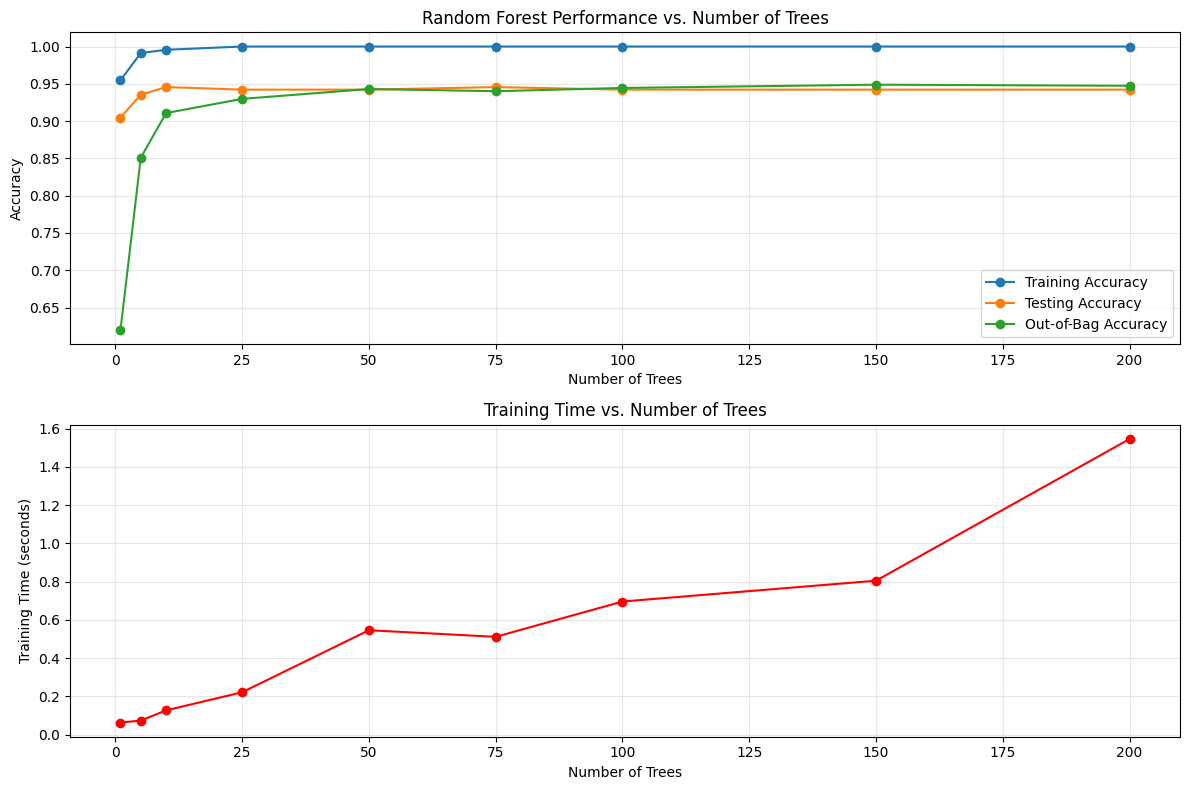

  Analyzing feature importance stability...


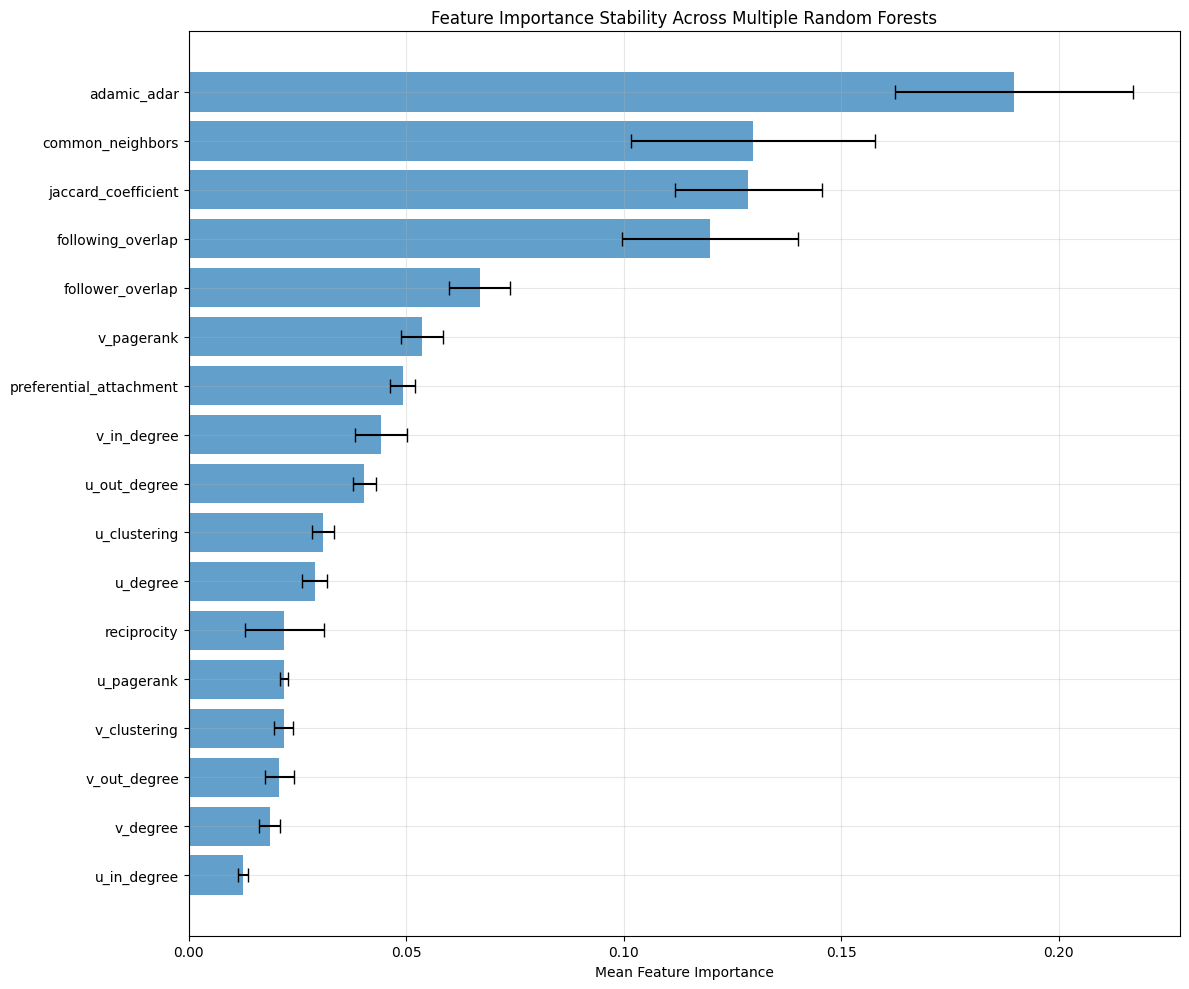

  Training final model with 100 trees...
  Generating visualization of a sample decision tree...

[7/7] Evaluating model performance...
Performance metrics:
  - ROC AUC Score: 0.9866
  - Average Precision Score: 0.9846


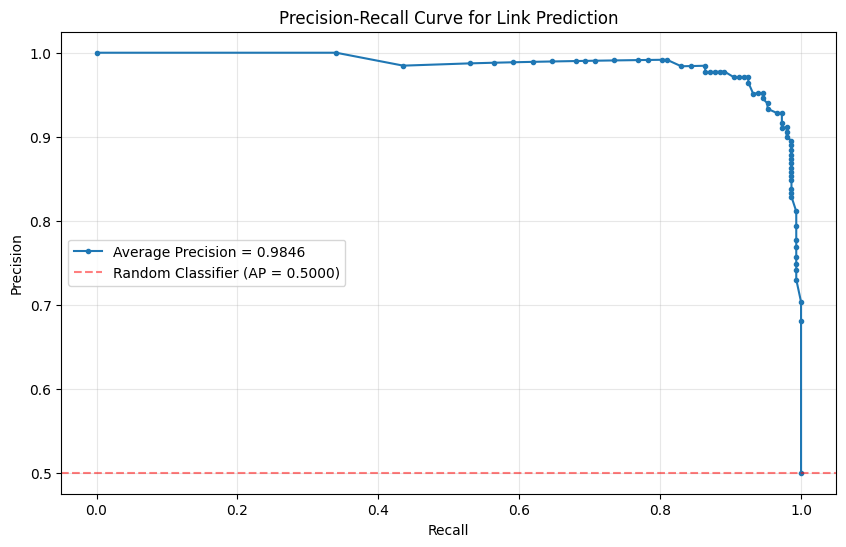

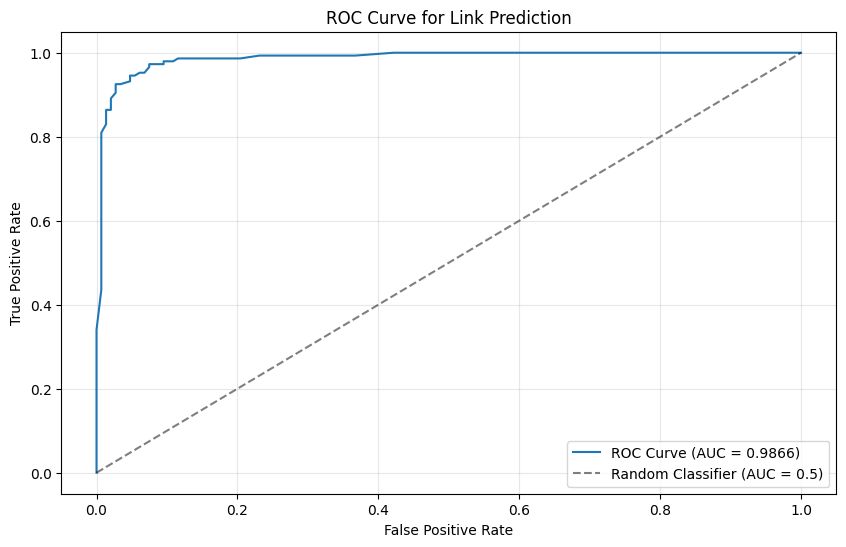

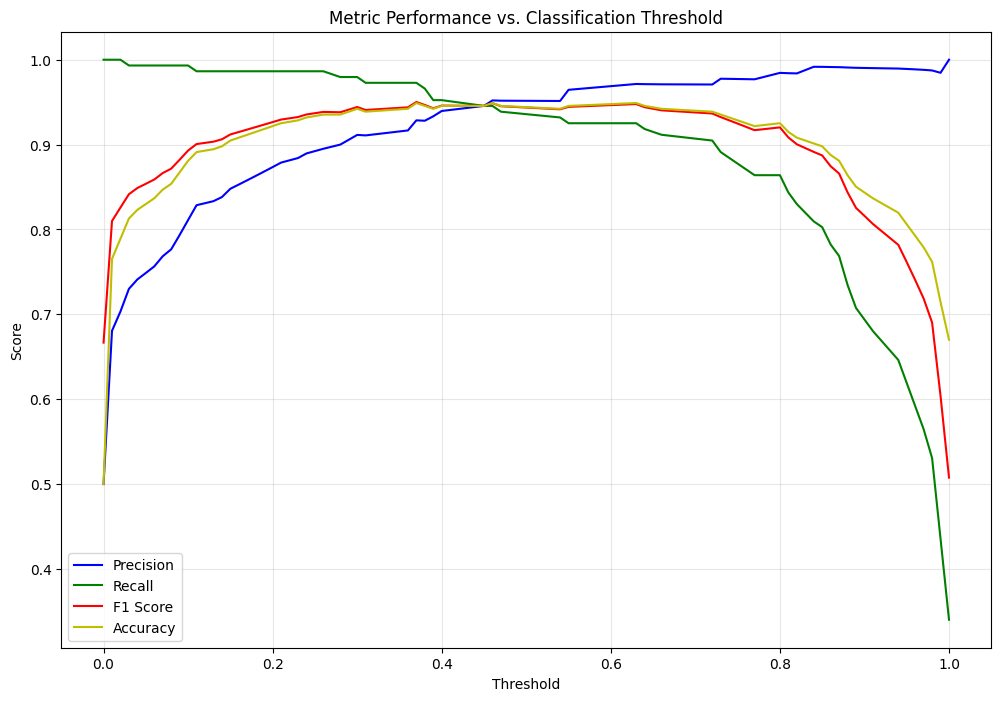


Link Prediction Results Summary:
ROC AUC Score: 0.9866
Average Precision Score: 0.9846

Top 5 Most Important Features:
  - adamic_adar: 0.1849
  - jaccard_coefficient: 0.1427
  - following_overlap: 0.1388
  - common_neighbors: 0.1100
  - follower_overlap: 0.0649


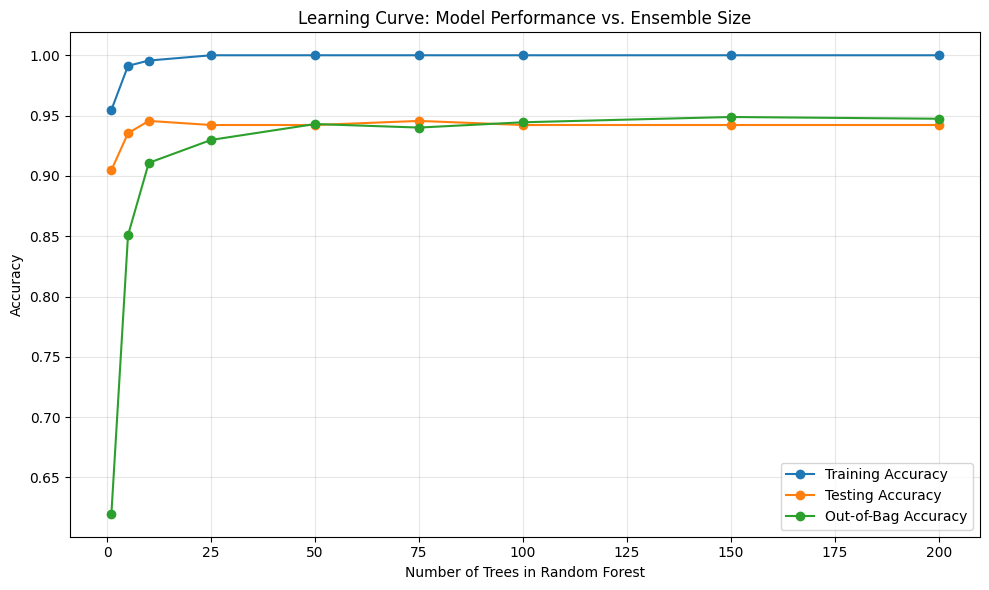

In [ ]:
if __name__ == "__main__":
    # URL of the dataset
    url = "https://snap.stanford.edu/data/twitter.tar.gz"
    data_dir = "./data"

    # Download and extract the dataset
    download_data(url, data_dir)

    # List available ego networks
    ego_networks = []
    for filename in os.listdir(os.path.join(data_dir, "twitter")):
        if filename.endswith(".edges"):
            ego_networks.append(filename.split(".")[0])

    print(f"Found {len(ego_networks)} ego networks: {ego_networks}")

    # Select a single ego network to analyze
    if len(ego_networks) > 0:
        # You can change this index to select a different network
        network_index = 0
        ego_id = ego_networks[network_index]

        try:
            # Run link prediction
            results = run_link_prediction(ego_id, data_dir)

            # Print a summary of the results
            print("\nLink Prediction Results Summary:")
            print(f"ROC AUC Score: {results['auc_score']:.4f}")
            print(f"Average Precision Score: {results['ap_score']:.4f}")

            print("\nTop 5 Most Important Features:")
            sorted_features = sorted(results['feature_importance'].items(), key=lambda x: x[1], reverse=True)
            for feature, importance in sorted_features[:5]:
                print(f"  - {feature}: {importance:.4f}")

            # Plot training and testing accuracy vs. number of trees
            plt.figure(figsize=(10, 6))
            plt.plot(results['n_estimators_list'], results['train_scores'], 'o-', label='Training Accuracy')
            plt.plot(results['n_estimators_list'], results['test_scores'], 'o-', label='Testing Accuracy')
            plt.plot(results['n_estimators_list'], results['oob_scores'], 'o-', label='Out-of-Bag Accuracy')

            plt.xlabel('Number of Trees in Random Forest')
            plt.ylabel('Accuracy')
            plt.title('Learning Curve: Model Performance vs. Ensemble Size')
            plt.grid(alpha=0.3)
            plt.legend()

            plt.tight_layout()
            plt.savefig(f"learning_curve_ego_{ego_id}.png", dpi=300, bbox_inches='tight')
            plt.show()

        except Exception as e:
            print("\nAn error occurred during link prediction:")
            print(str(e))
            import traceback
            traceback.print_exc()
    else:
        print("No ego networks found. Check the dataset extraction.")